In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt; plt.style.use('bmh')
import collections, pathlib, random, itertools, collections, math, json
np.random.seed(0)

In [301]:
results_path = pathlib.Path('/mnt/dfs/qtim/clu/ISBI/results/')
figures_path = pathlib.Path('/mnt/dfs/qtim/clu/ISBI/figures/')

In [248]:
def get_q_hat(calibration_scores, labels, alpha=0.05):
    if not isinstance(calibration_scores, torch.Tensor):
        calibration_scores = torch.tensor(calibration_scores)
    n = calibration_scores.shape[0]
    
    #  sort scores and returns values and index that would sort classes
    values, indices = calibration_scores.sort(dim=1, descending=True)
    
    #  sum up all scores cummulatively and return to original index order 
    cum_scores = values.cumsum(1).gather(1, indices.argsort(1))[range(n), labels]
    
    #  get quantile with small correction for finite sample sizes
    q_hat = torch.quantile(cum_scores, np.ceil((n + 1) * (1 - alpha)) / n)
    return q_hat

def conformal_inference(scores, q_hat):
    if not isinstance(scores, torch.Tensor):
        scores = torch.tensor(scores)
    if q_hat >= 1:
        q_hat -= 1e-4
    n = scores.shape[0]
    values, indices = scores.sort(dim=1, descending=True)
    
    #  number of each confidence prediction set to acheive coverage
    set_sizes = (values.cumsum(1) > q_hat).int().argmax(dim=1)
    confidence_sets = [indices[i][0:(set_sizes[i] + 1)] for i in range(n)]
    return [x.tolist() for x in confidence_sets]

In [249]:
def get_conformal_predictions(parition, index=1, alpha=0.05):
    index = str(index)
    val_pred = partition['pred'][index]['val_pred']
    val_label = partition['pred'][index]['val_label']
    test_pred = partition['pred'][index]['test_pred']
    
    qhat = get_q_hat(val_pred, val_label, alpha=alpha)
    conf_pred = conformal_inference(test_pred, qhat)
    return conf_pred, qhat

def naive_sets(predictions, alpha=0.2):
    sorted_index = np.asarray(predictions).argsort(1)
    threshold = (np.cumsum(np.sort(predictions, 1), 1) <= (1 - alpha)).sum(1)
    pred_sets = collections.defaultdict(list)
    for row, pred in zip(*np.nonzero(sorted_index <= threshold[:, np.newaxis])):
        pred_sets[row].append(pred)
    return list(pred_sets.values())

In [251]:
def accuracy(pred_sets, labels):
    corr = 0; count = 0
    for pred, label in zip(pred_sets, labels):
        corr += 1 if label == pred[0] else 0
        count += 1
    return corr / count

def validity(pred_sets, labels):
    corr = 0; count = 0
    for pred, label in zip(pred_sets, labels):
        corr += 1 if label in pred else 0
        count += 1
    return corr / count
        
def cardinality(pred_sets):
    sizes = []
    for pred in pred_sets:
        sizes.append(len(pred))
    return sum(sizes) / len(sizes)

### Ablations
* Calibration size vs coverage
* Number of rounds vs coverage

### Experiements
* Federated calbiration vs indidvivudal calibration
* Entropy vs cardinality

In [394]:
# datasets = {
#     'BloodMNIST': json.load(open('results/noise-bloodmnist-results.json')),
#     'DermaMNIST': json.load(open('results/noise-dermamnist-results.json')),
#     'PathMNIST': json.load(open('results/noise-pathmnist-results.json')),
#     'TissueMNIST': json.load(open('results/noise-tissuemnist-results.json')),
#     'RetinaMNIST': json.load(open('results/noise-retinamnist-results.json')),
#     'OrganMNIST3d': json.load(open('results/noise-organmnist3d-results.json')),
# }

datasets = {
    'BloodMNIST': json.load(open('results/heavy-noise-bloodmnist-results.json')),
    'DermaMNIST': json.load(open('results/heavy-noise-dermamnist-results.json')),
    'PathMNIST': json.load(open('results/heavy-noise-pathmnist-results.json')),
    'TissueMNIST': json.load(open('results/heavy-noise-tissuemnist-results.json')),
    'RetinaMNIST': json.load(open('results/heavy-noise-retinamnist-results.json')),
    'OrganMNIST3d': json.load(open('results/heavy-noise-organmnist3d-results.json')),
}

In [395]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [396]:
results = {}

for k, v in datasets.items():
    _dataset = v
    qhat = {
        alpha: [
            get_q_hat(
                np.array(_dataset[str(i)]['part-4']['pred']['0']['val_pred']),
                np.array(_dataset[str(i)]['part-4']['pred']['0']['val_label']),
                alpha=alpha,
            ).item() for i in range(10)
        ]
        for alpha in alphas
    }

    acc = {
        alpha:
        [
            accuracy(
                conformal_inference(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    qhat[alpha][i]
                ),
                np.array(_dataset[str(i)]['part-4']['pred']['0']['test_label'])
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    val = {
        alpha:
        [
            validity(
                conformal_inference(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    qhat[alpha][i]
                ),
                np.array(_dataset[str(i)]['part-4']['pred']['0']['test_label'])
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    car = {
        alpha:
        [
            cardinality(
                conformal_inference(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    qhat[alpha][i]
                ),
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    naive_acc = {
        alpha:
        [
            accuracy(
                naive_sets(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    alpha=alpha
                ),
                np.array(_dataset[str(i)]['part-4']['pred']['0']['test_label'])
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    naive_val = {
        alpha:
        [
            validity(
                naive_sets(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    alpha=alpha
                ),
                np.array(_dataset[str(i)]['part-4']['pred']['0']['test_label'])
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    naive_car = {
        alpha:
        [
            cardinality(
                naive_sets(
                    np.array(_dataset[str(i)]['part-4']['pred']['0']['test_pred']),
                    alpha=alpha
                ),
            ) for i in range(10)
        ]
        for alpha in alphas
    }

    acc = np.array(list(acc.values()))
    val = np.array(list(val.values()))
    car = np.array(list(car.values()))
    naive_acc = np.array(list(naive_acc.values()))
    naive_val = np.array(list(naive_val.values()))
    naive_car = np.array(list(naive_car.values()))
    
    results[k] = dict(acc=acc, val=val, car=car, naive_acc=naive_acc, naive_val=naive_val, naive_car=naive_car)

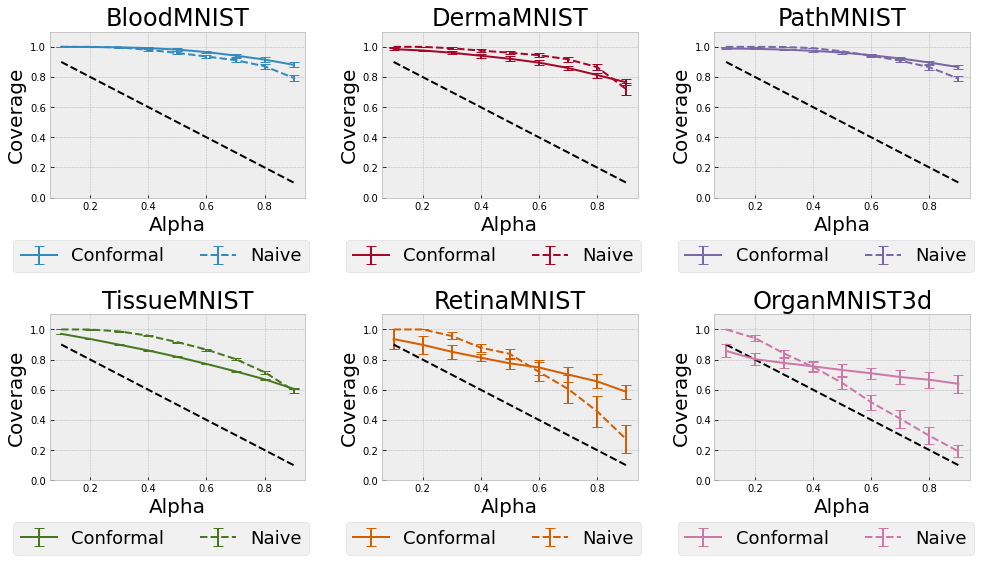

In [397]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
for i in range(2):  # rows
    for j in range(3):  # columns
        index = i * 3 + j
        name = list(datasets.keys())[index]
        ax = axes[i, j]
        ax.plot([0.1, 0.9], [0.9, 0.1], '--k')
#         ax.plot([0.1, 0.9], [results[name]['acc'].mean(), results[name]['acc'].mean()], 
#                 label='Accuracy', c='k', ls=':', lw=4)
        ax.set_title(f'{name}', fontsize=24)
        ax.set_xlabel('Alpha', fontsize=20)
        ax.set_ylabel('Coverage', fontsize=20)
        ax.set_ylim(0, 1.1)
        ax.errorbar(
            alphas,
            results[name]['val'].mean(1),
            yerr=results[name]['val'].std(1),
            label='Conformal',
            c=f'C{index}',
            capsize=5,
            lw=2,
        )
        ax.errorbar(
            alphas,
            results[name]['naive_val'].mean(1),
            yerr=results[name]['naive_val'].std(1),
            label='Naive',
            c=f'C{index}',
            ls='--',
            capsize=5,
            lw=2,
        )
#         ax.legend(loc='lower left', fontsize=20)
        ax.legend(fontsize=18, bbox_to_anchor=(-0.05, -0.5, 1.1, .3), ncol=2)
fig.tight_layout()
plt.savefig(figures_path / 'heavy-coverage')

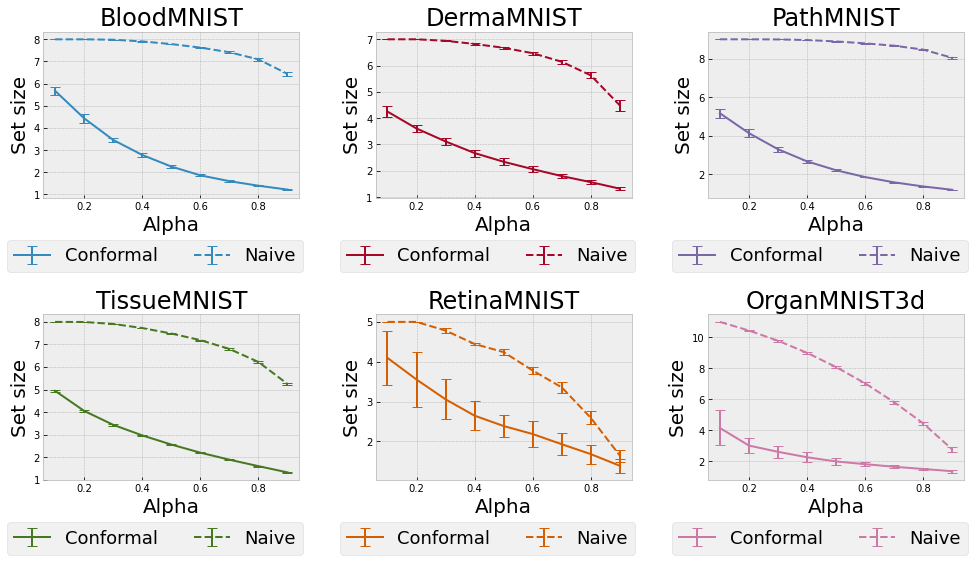

In [398]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
for i in range(2):  # rows
    for j in range(3):  # columns
        index = i * 3 + j
        name = list(datasets.keys())[index]
        ax = axes[i, j]
        ax.set_title(f'{name}', fontsize=24)
        ax.set_xlabel('Alpha', fontsize=20)
        ax.set_ylabel('Set size', fontsize=20)
#         ax.set_ylim(0, 1.1)
        ax.errorbar(
            alphas,
            results[name]['car'].mean(1),
            yerr=results[name]['car'].std(1),
            label='Conformal',
            c=f'C{index}',
            capsize=5,
            lw=2,
        )
        ax.errorbar(
            alphas,
            results[name]['naive_car'].mean(1),
            yerr=results[name]['naive_car'].std(1),
            label='Naive',
            c=f'C{index}',
            ls='--',
            capsize=5,
            lw=2,
        )
#         ax.legend(loc='lower right', fontsize=16)
        ax.legend(fontsize=18, bbox_to_anchor=(-0.05, -0.5, 1.1, .3), ncol=2)

fig.tight_layout()
plt.savefig(figures_path / 'heavy-cardinality')

In [399]:
i = 2
for k, v in results.items():
    print('\n', k)
    acc = v['acc']
    val = v['val']
    car = v['car']
    naive_acc = v['naive_acc']
    naive_val = v['naive_val']
    naive_car = v['naive_car']
    print('Accuracy\t', f'{acc.mean(1)[i]:.1%}', '+/-', round(acc.std(1)[i], 3))
    print('Validity\t', f'{val.mean(1)[i]:.1%}', '+/-', round(val.std(1)[i], 3))
    print('Cardinality\t', f'{car.mean(1)[i]:.1f}', '+/-', round(car.std(1)[i], 2))
#     print('Naive Accuracy\t', f'{naive_acc.mean(1)[i]:.1%}', '+/-', round(naive_acc.std(1)[i], 3))
#     print('Naive Validity\t', f'{naive_val.mean(1)[i]:.1%}', '+/-', round(naive_val.std(1)[i], 3))
#     print('Naive Cardinality\t', f'{naive_car.mean(1)[i]:.1%}', '+/-', round(naive_car.std(1)[i], 3))


 BloodMNIST
Accuracy	 82.2% +/- 0.018
Validity	 99.7% +/- 0.002
Cardinality	 3.5 +/- 0.11

 DermaMNIST
Accuracy	 68.8% +/- 0.021
Validity	 96.1% +/- 0.01
Cardinality	 3.1 +/- 0.12

 PathMNIST
Accuracy	 80.9% +/- 0.01
Validity	 98.2% +/- 0.004
Cardinality	 3.3 +/- 0.14

 TissueMNIST
Accuracy	 53.0% +/- 0.002
Validity	 89.9% +/- 0.003
Cardinality	 3.4 +/- 0.03

 RetinaMNIST
Accuracy	 49.5% +/- 0.051
Validity	 85.2% +/- 0.047
Cardinality	 3.1 +/- 0.5

 OrganMNIST3d
Accuracy	 56.7% +/- 0.062
Validity	 77.8% +/- 0.035
Cardinality	 2.6 +/- 0.37


In [400]:
dataset['0']['part-4']['entropy']

{'0.1': {'0': 8.0, '1': 7.5, '2': 9.0, '3': 10.0},
 '0.2': {'0': 6.0, '1': 7.0, '2': 7.5, '3': 8.5},
 '0.30000000000000004': {'0': 4.0, '1': 5.0, '2': 4.5, '3': 7.0},
 '0.4': {'0': 3.0, '1': 4.5, '2': 3.0, '3': 6.0},
 '0.5': {'0': 3.0, '1': 4.0, '2': 3.0, '3': 5.0},
 '0.6': {'0': 2.0, '1': 2.5, '2': 2.5, '3': 3.0},
 '0.7000000000000001': {'0': 2.0, '1': 2.0, '2': 2.0, '3': 3.0},
 '0.8': {'0': 1.5, '1': 2.0, '2': 2.0, '3': 2.5},
 '0.9': {'0': 1.0, '1': 1.0, '2': 2.0, '3': 1.5}}

In [401]:
for name, dataset in datasets.items():
    print(name)
    for k, v in dataset['0']['part-4']['entropy'].items():
        print(round(float(k), 1), np.mean(list(v.values())).round(1), np.std(list(v.values())).round(1))

BloodMNIST
0.1 4.4 1.2
0.2 3.6 1.1
0.3 3.1 0.7
0.4 2.7 0.6
0.5 2.1 0.4
0.6 1.8 0.2
0.7 1.6 0.1
0.8 1.3 0.1
0.9 1.2 0.1
DermaMNIST
0.1 4.4 0.5
0.2 3.6 0.3
0.3 3.2 0.4
0.4 2.7 0.3
0.5 2.4 0.3
0.6 2.2 0.3
0.7 1.6 0.2
0.8 1.5 0.2
0.9 1.2 0.2
PathMNIST
0.1 4.1 1.5
0.2 3.4 1.3
0.3 2.8 1.1
0.4 2.3 0.8
0.5 2.0 0.6
0.6 1.8 0.4
0.7 1.5 0.3
0.8 1.3 0.2
0.9 1.2 0.1
TissueMNIST
0.1 5.4 0.2
0.2 4.4 0.2
0.3 3.7 0.2
0.4 3.2 0.2
0.5 2.8 0.1
0.6 2.4 0.1
0.7 2.1 0.0
0.8 1.7 0.0
0.9 1.4 0.0
RetinaMNIST
0.1 4.8 0.4
0.2 4.0 0.0
0.3 3.5 0.5
0.4 3.0 0.0
0.5 2.8 0.4
0.6 2.2 0.4
0.7 2.0 0.0
0.8 2.0 0.0
0.9 1.5 0.5
OrganMNIST3d
0.1 4.6 0.2
0.2 3.6 0.6
0.3 3.0 0.6
0.4 2.8 0.6
0.5 2.4 0.4
0.6 2.0 0.4
0.7 1.9 0.2
0.8 1.9 0.2
0.9 1.5 0.4
